In [41]:
import ccxt
import pandas as pd
import numpy as np
from typing import Iterable
import time
import matplotlib.pyplot as plt

In [42]:
def download_and_plot(
    cryptos,
    market,
    timeframe_download,
    start_date,
    end_date,
    plot=False,
    market_type='spot',
    limit_per_call=1000,
    max_tries=3
):
    """
    Scarica OHLCV via ccxt per una lista di crypto e (opzionalmente) plottale.
    
    Parametri
    ---------
    cryptos : list[str]
        Lista di ticker base (es. ["BTC", "ETH"]).
    market : str
        Nome dell'exchange per ccxt (es. "bybit", "binance", ...).
    timeframe_download : str
        Timeframe ccxt (es. '1d', '4h', '1h', ...).
    start_date, end_date : str o pd.Timestamp
        Intervallo temporale richiesto (inclusivo sul cap finale).
    plot : bool
        Se True, mostra un grafico per ogni crypto con i prezzi (close) nell'intervallo.
    market_type : str
        'spot', 'futures' (linear) oppure 'inverse'.
    limit_per_call : int
        Numero max di candele richieste per chiamata a fetch_ohlcv (dipende dall'exchange).
    max_tries : int
        Numero di tentativi per gestire temporanei errori di rete/exchange.

    Ritorna
    -------
    dict[str, pd.DataFrame]
        Dizionario { 'BTC' : df, 'ETH' : df, ... } con colonne
        ['open','high','low','close','volume'] e index = timestamp (UTC).
    """
    # Costruisco l'exchange
    exchange_class = getattr(ccxt, market)
    exchange_params = {'enableRateLimit': True}
    if market_type in ['futures', 'inverse']:
        exchange_params['options'] = {
            'defaultType': 'linear' if market_type == 'futures' else 'inverse'
        }
    exchange = exchange_class(exchange_params)

    # Carico i mercati
    exchange.load_markets()

    # Costruisco i simboli per tipo mercato
    if market_type == 'spot':
        cryptos_pairs = [f"{c}/USDT" for c in cryptos]
        suffix_to_remove = '/USDT'
    elif market_type == 'futures':  # linear USDT-margined
        # molti exchange usano il formato <base>/USDT:USDT per linear futures
        cryptos_pairs = [f"{c}/USDT:USDT" for c in cryptos]
        suffix_to_remove = '/USDT:USDT'
    elif market_type == 'inverse':  # inverse USD-margined
        cryptos_pairs = [f"{c}/USD" for c in cryptos]
        suffix_to_remove = '/USD'
    else:
        raise ValueError("Tipo di mercato non valido. Usa 'spot', 'futures' o 'inverse'.")

    # Timestamp (ms) per fetch_ohlcv
    start_ts = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_ts = int(pd.Timestamp(end_date).timestamp() * 1000)

    data_frames = {}

    # Utility per backoff semplice
    def _sleep_rate_limit():
        rl = getattr(exchange, 'rateLimit', 1000)
        time.sleep(max(rl, 250) / 1000.0)

    for pair in cryptos_pairs:
        if pair not in exchange.markets:
            raise ValueError(f"Il mercato {pair} non è disponibile su {market}.")

        print(f"[{market}] Scarico {pair} {timeframe_download} da {start_date} a {end_date}...")
        ohlcv = []
        since = start_ts
        last_batch_last_ts = None

        while since <= end_ts:
            # Retry basilare
            batch = None
            for attempt in range(1, max_tries + 1):
                try:
                    batch = exchange.fetch_ohlcv(pair, timeframe_download, since, limit=limit_per_call)
                    break
                except Exception as e:
                    if attempt == max_tries:
                        raise
                    # piccolo backoff
                    time.sleep(0.5 * attempt)

            if not batch:
                # Nessun dato ulteriore
                break

            ohlcv.extend(batch)

            # Protezione da loop infinito: se l'ultimo ts non avanza, salto in avanti di un'unità
            last_ts = batch[-1][0]
            if last_batch_last_ts is not None and last_ts <= last_batch_last_ts:
                # fallback: incremento di un "tick"
                since = last_ts + 1
            else:
                since = last_ts + 1
                last_batch_last_ts = last_ts

            _sleep_rate_limit()

        if not ohlcv:
            # Nessun dato, creo DF vuoto
            df = pd.DataFrame(columns=['open', 'high', 'low', 'close', 'volume'])
            data_frames[pair] = df
            continue

        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
        df.set_index('timestamp', inplace=True)

        # Filtro intervallo richiesto (inclusivo sul cap finale)
        df = df[(df.index >= pd.Timestamp(start_date, tz='UTC')) & (df.index <= pd.Timestamp(end_date, tz='UTC'))]

        # Tipi numerici coerenti
        for col in ['open', 'high', 'low', 'close', 'volume']:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        data_frames[pair] = df

    # Mappo a chiave base (BTC, ETH, ...) rimuovendo il suffisso
    out = {k.replace(suffix_to_remove, ''): v for k, v in data_frames.items()}

    # Plot: un grafico per ogni crypto
    if plot:
        for base, df in out.items():
            if df is None or df.empty:
                print(f"[plot] Nessun dato da plottare per {base} nell'intervallo selezionato.")
                continue

            plt.figure(figsize=(10, 4))
            plt.plot(df.index, df['close'])
            plt.title(f"{base} - Close price ({timeframe_download})\n{pd.Timestamp(start_date)} → {pd.Timestamp(end_date)}")
            plt.xlabel("Data (UTC)")
            plt.ylabel("Prezzo di chiusura")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    return out


In [43]:
def backtest_trailing_stop(series: pd.Series, perc_ts: float) -> float:
    """
    Calcolo il fattore finale usando un trailing stop percentuale.

    - compro al primo prezzo P0;
    - attivo il TS quando il prezzo raggiunge P0/(1-perc_ts);
    - stop = (1-perc_ts) * max(prezzo) dall’attivazione in poi, aggiornato sui nuovi massimi;
    - se il prezzo scende sotto lo stop, esco allo stop (assunzione prudente);
    - se non scatta mai, esco a fine serie all’ultimo prezzo;
    - ritorno il fattore = prezzo_uscita / P0.
    """
    s = series.dropna()
    if s.empty:
        return np.nan

    P0 = float(s.iloc[0])
    activation_level = P0 / (1.0 - perc_ts)

    activated = False
    max_since_act = None
    stop_level = None

    for price in s.iloc[1:]:
        p = float(price)

        # attivo quando supero la soglia
        if not activated and p >= activation_level:
            activated = True
            max_since_act = p
            stop_level = (1.0 - perc_ts) * max_since_act

        if activated:
            # aggiorno max e stop
            if p > max_since_act:
                max_since_act = p
                stop_level = (1.0 - perc_ts) * max_since_act

            # rottura dello stop → esco allo stop
            if p <= stop_level:
                exit_price = stop_level
                return exit_price / P0

    # mai colpito: esco a fine serie
    exit_price = float(s.iloc[-1])
    return exit_price / P0


def grid_trailing_stops(df_prices: pd.DataFrame, perc_list: Iterable[float]) -> pd.DataFrame:
    """
    Matrice: righe = crypto, colonne = percentuali (es. '1%', '2%', ...),
    valore = fattore finale (prezzo_uscita / P0).
    """
    cols = list(df_prices.columns)
    results = pd.DataFrame(index=cols, columns=[f"{int(p*100)}%" for p in perc_list], dtype=float)

    for col in cols:
        ser = df_prices[col]
        for p in perc_list:
            results.loc[col, f"{int(p*100)}%"] = backtest_trailing_stop(ser, p)

    return results

In [ ]:
# Parametri per il download
cryptos = ['BTC', 'ETH', 'XRP', 'AVAX', 'AXS', 'DOGE']
market = 'bybit'
timeframe_download = '1d'
start_date = '2020-09-01' # scegliere fra 'total' e 'pre-trump' e 'updated'
end_date = '2022-03-01'
plot = True  # Imposta a True per visualizzare i grafici
market_type = 'futures'

[bybit] Scarico BTC/USDT:USDT 1d da 2020-09-01 a 2022-03-01...
[bybit] Scarico ETH/USDT:USDT 1d da 2020-09-01 a 2022-03-01...
[bybit] Scarico XRP/USDT:USDT 1d da 2020-09-01 a 2022-03-01...
[bybit] Scarico AVAX/USDT:USDT 1d da 2020-09-01 a 2022-03-01...
[bybit] Scarico AXS/USDT:USDT 1d da 2020-09-01 a 2022-03-01...
[bybit] Scarico DOGE/USDT:USDT 1d da 2020-09-01 a 2022-03-01...


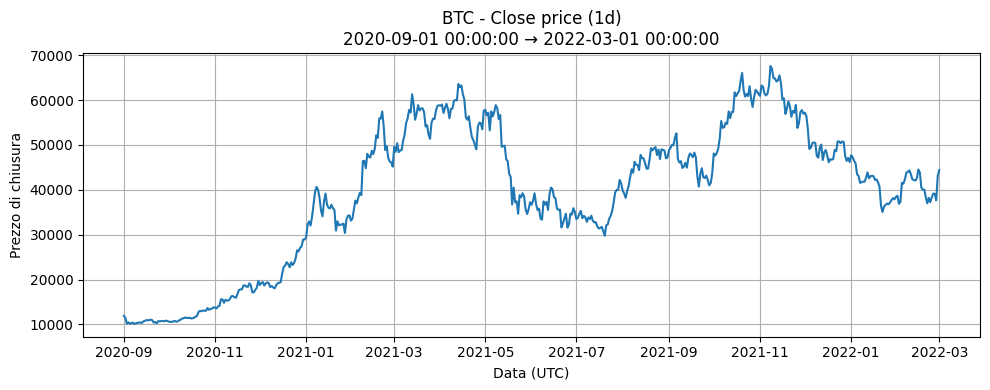

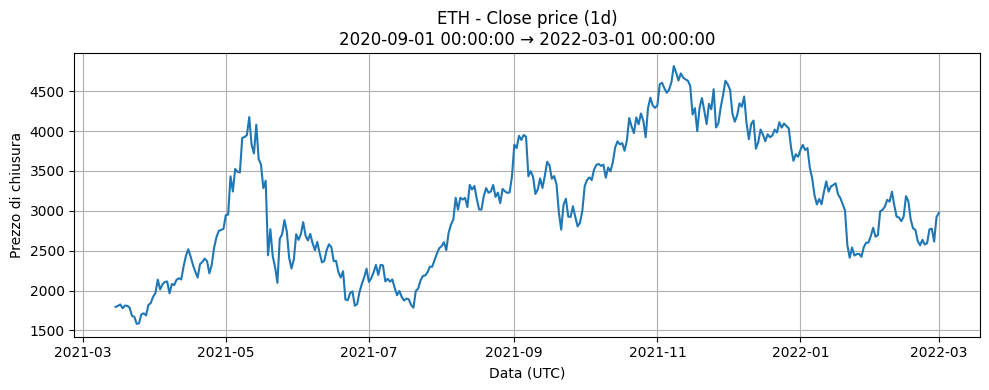

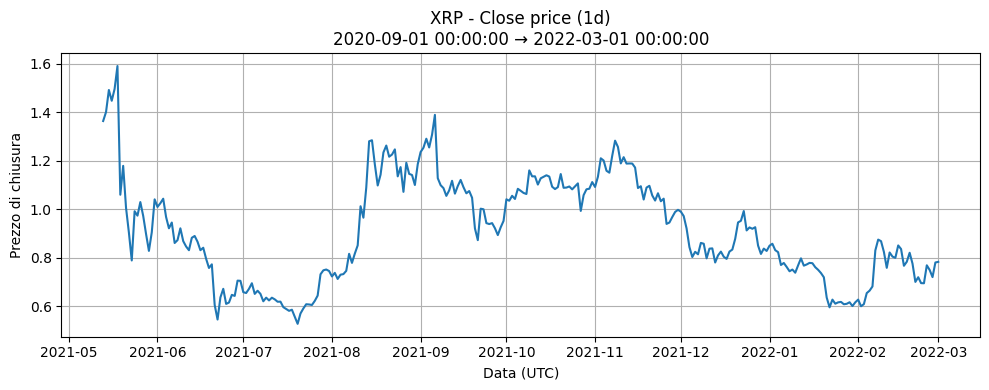

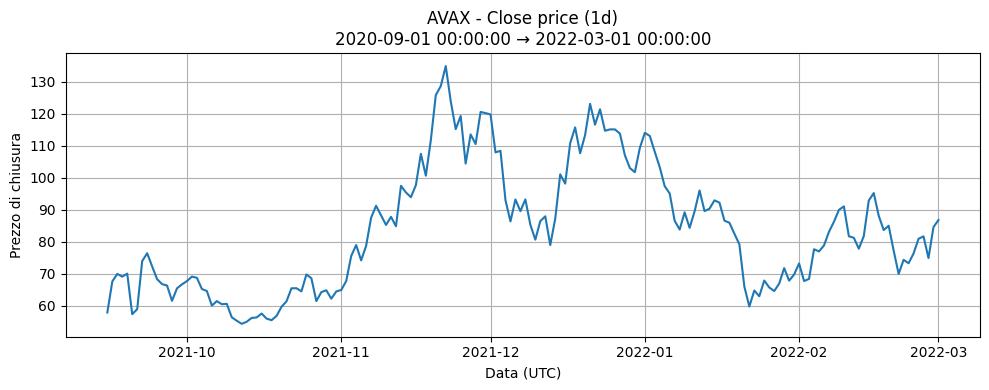

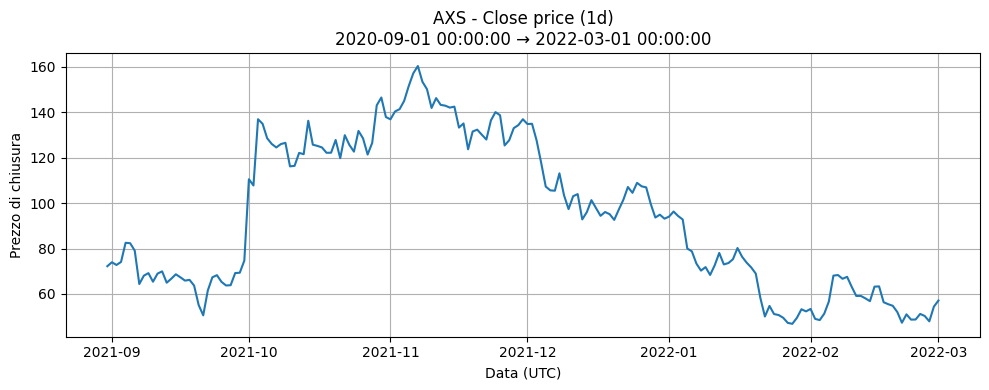

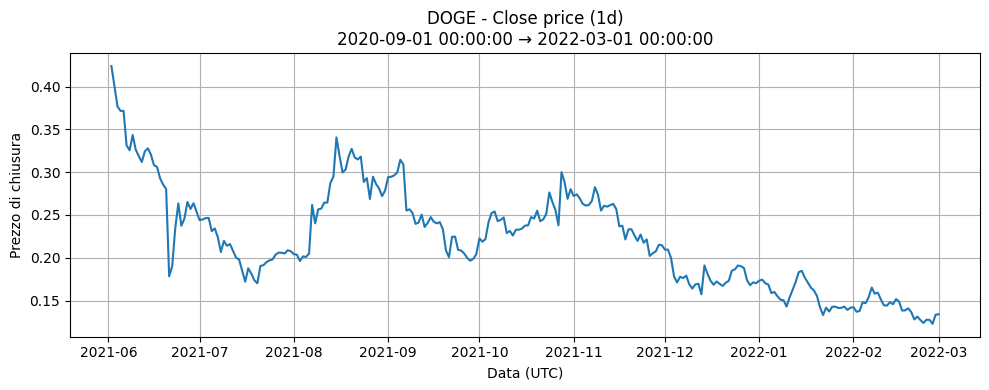

In [45]:
data = download_and_plot(cryptos, market, timeframe_download, start_date, end_date, plot, market_type)

In [46]:
df_prices = pd.DataFrame(index=data[list(data.keys())[0]].index)
for crypto in cryptos:
    df_prices[crypto] = data[crypto]['close']

In [47]:
df_prices

,BTC,ETH,XRP,AVAX,AXS,DOGE
timestamp,,,,,,
2020-09-01 00:00:00+00:00,11927.5,NaN,NaN,NaN,NaN,NaN
2020-09-02 00:00:00+00:00,11388.5,NaN,NaN,NaN,NaN,NaN
2020-09-03 00:00:00+00:00,10145.5,NaN,NaN,NaN,NaN,NaN
2020-09-04 00:00:00+00:00,10448.5,NaN,NaN,NaN,NaN,NaN
2020-09-05 00:00:00+00:00,10161.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2022-02-25 00:00:00+00:00,39174.5,2766.75,0.7697,80.965,51.180,0.1275
2022-02-26 00:00:00+00:00,39094.5,2776.35,0.7505,81.725,50.265,0.1275
2022-02-27 00:00:00+00:00,37665.0,2613.55,0.7211,74.950,47.910,0.1228


In [48]:
df_prices.dropna(inplace=True)
df_prices

,BTC,ETH,XRP,AVAX,AXS,DOGE
timestamp,,,,,,
2021-09-15 00:00:00+00:00,48100.0,3614.25,1.1217,57.945,68.645,0.2475
2021-09-16 00:00:00+00:00,47766.0,3570.50,1.0915,67.645,67.315,0.2421
2021-09-17 00:00:00+00:00,47276.0,3401.60,1.0665,70.010,65.860,0.2401
2021-09-18 00:00:00+00:00,48300.0,3435.30,1.0759,69.145,66.190,0.2416
2021-09-19 00:00:00+00:00,47274.5,3330.20,1.0481,70.085,63.675,0.2332
...,...,...,...,...,...,...
2022-02-25 00:00:00+00:00,39174.5,2766.75,0.7697,80.965,51.180,0.1275
2022-02-26 00:00:00+00:00,39094.5,2776.35,0.7505,81.725,50.265,0.1275
2022-02-27 00:00:00+00:00,37665.0,2613.55,0.7211,74.950,47.910,0.1228


In [51]:
# percentuali dal 1% al 10%
perc_list = np.arange(0.01, 0.31, 0.01)

# calcolo la matrice risultati
results = grid_trailing_stops(df_prices, perc_list)

# opzionale: percentuali migliori per ogni crypto
best_ts = results.idxmax(axis=1)
best_factor = results.max(axis=1)

display(results)
display(pd.DataFrame({"best_TS": best_ts, "best_factor": best_factor}))

,1%,2%,3%,4%,5%,6%,6%,8%,9%,10%,...,21%,22%,23%,24%,25%,26%,27%,28%,29%,30%
BTC,1.138963,1.127458,1.332086,1.318353,1.304621,1.277155,1.277155,1.263422,1.249689,1.235956,...,1.110328,1.096273,1.082218,1.068163,1.054109,1.040054,1.025999,1.011944,0.922859,0.922859
ETH,1.060465,1.049753,1.039041,1.106088,1.109391,1.086036,1.086036,1.225903,1.212578,1.199253,...,1.052678,1.039353,1.026028,1.012702,0.822536,0.822536,0.822536,0.822536,0.822536,0.822536
XRP,1.024597,1.014248,1.003899,1.036256,1.086948,1.064065,1.064065,1.052624,1.041182,1.029741,...,0.698939,0.698939,0.698939,0.698939,0.698939,0.698939,0.698939,0.698939,0.698939,0.698939
AVAX,1.196133,1.185319,1.173224,1.161129,1.149034,1.124843,1.124843,1.112748,1.100653,1.088558,...,1.042495,1.029298,1.016102,1.002906,1.746311,1.723027,1.699743,1.676459,1.653175,1.629890
AXS,1.593778,1.577679,1.935337,1.915385,1.895433,1.855529,1.855529,1.835577,1.815625,1.795673,...,1.845846,1.822481,1.799116,1.775751,1.752385,1.729020,1.705655,1.682290,1.658925,1.635560
DOGE,1.016400,1.006133,1.082873,1.071709,1.060545,1.038218,1.038218,1.027055,1.015891,1.004727,...,0.541414,0.541414,0.541414,0.541414,0.541414,0.541414,0.541414,0.541414,0.541414,0.541414


,best_TS,best_factor
BTC,3%,1.332086
ETH,8%,1.225903
XRP,5%,1.086948
AVAX,25%,1.746311
AXS,16%,1.962672
DOGE,3%,1.082873
